In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import os
import cv2

from collections import defaultdict
import tensorflow as tf

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.6f}'.format

import gym
from gym.wrappers import Monitor
import gym_ple

env = gym.make('FlappyBird-v0')

In [235]:
init_state = env.reset()

for _ in range(150):
    s, r, done, _ = env.step(env.action_space.sample())

In [5]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util

In [9]:
import numpy as np
from tf_unet.image_util import BaseDataProvider
import os
from skimage.io import imread

class FlappyBirdDataProvider(BaseDataProvider):
    channels = 3
    n_class = 3
    
    def __init__(self, folder, **kwargs):
        super(FlappyBirdDataProvider, self).__init__()
        
        images_folder = os.path.join(folder, "images")
        labels_folder = os.path.join(folder, "labels")
        
        self._read_images(images_folder, labels_folder)
        
    def _read_images(self, images_folder, labels_folder):
        image_names = os.listdir(images_folder)
        
        self.images = []
        
        for image_name in tqdm_notebook(image_names[:10000]):
            image_path = os.path.join(images_folder, image_name)
            label_path = os.path.join(labels_folder, image_name)
            
            image = imread(image_path)[:, :, :3]
            label_ = imread(label_path)
            
            label = np.zeros(image.shape[:-1] + (self.n_class, ))
            label[:, :, 0] = (label_ == 0) | (label_ == 255)
            label[:, :, 1] = (label_ == 1)
            label[:, :, 2] = (label_ == 2)
            
            self.images.append((image, label))
            
        
    def _next_data(self):
        idx = np.random.randint(len(self.images))
        image, label = self.images[idx]
        return image, label
    
generator = FlappyBirdDataProvider("data")

In [12]:
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=16)
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(learning_rate=0.02))

2018-06-25 11:30:00,193 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [ ]:
path = trainer.train(generator, "./unet_trained", training_iters=20, epochs=100, display_step=2)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2018-06-24 17:29:43,422 Restoring parameters from ./unet_trained/model.ckpt
2018-06-24 17:29:43,533 Model restored from file: ./unet_trained/model.ckpt


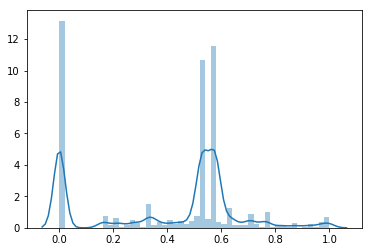

In [242]:
sns.distplot(x_test[0].ravel())

In [238]:
s[:-112].shape

(400, 288, 3)

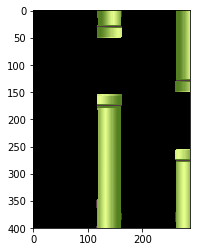

In [243]:
plt.imshow(cropper.crop_image(s[:-112] / 255))

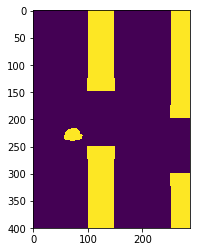

In [20]:
plt.imshow(y_test[0, :, :, 1:].any(axis=2))

In [21]:
def score_prediction(pred, label):
    label_binary = label[:, :, 1:].any(axis=2)
    
    intersection = (pred & label_binary).sum()
    union = (pred | label_binary).sum()
    
    return intersection / union if union > 0 else 0.

/home/evgenii/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


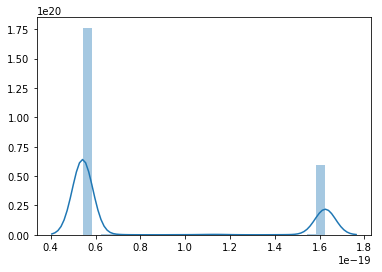

In [36]:
sns.distplot(mask_.ravel())

In [230]:
from skimage.transform import resize

class SemanticSegmentationCropper:
    TUBE_WIDTH = 46
    
    def __init__(self, model_path):
        self.net = unet.Unet(channels=3, n_class=3, layers=3, features_root=16)
        
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        net.restore(self.sess, model_path)
        
        self.y_dummy = np.empty((1, 400, 288, 3))
        
    def __predict(self, image):
        return self.sess.run(self.net.predicter, feed_dict={self.net.x: [image], 
                                                            self.net.y: self.y_dummy, 
                                                            self.net.keep_prob: 1.})[0]
        
    def crop_image(self, image):
        pred = self.__predict(image)
        mask = self.__process_prediction(pred)
        mask = self.__process_mask(mask)
        
        return mask * image
        
    def __process_prediction(self, prediction):
        mask = np.zeros(prediction.shape[:-1], dtype=int)

        for i in [1, 2]:
            threshold = prediction[:, :, i].max() - 0.05
            mask = mask | (prediction[:, :, i] > threshold)

        return mask
    
    def __process_mask(self, mask):
        mask = np.pad(mask, 20, mode="reflect")
        self.__repair_mask(mask)
        return mask[:, :, np.newaxis]
    
   

    def __change_row_left(self, mask, x):
        row = np.zeros(20)

        if mask[x, 20] == 1:
            streak = mask[x, 20:20+self.TUBE_WIDTH].sum()
            to_add = self.TUBE_WIDTH - streak
            row[-min(20, to_add):] = 1

        mask[x, :20] = row

    def __change_row_right(self, mask, x):
        row = np.zeros(20)

        if mask[x, -21] == 1:
            streak = mask[x, -21-self.TUBE_WIDTH:-21].sum()
            to_add = self.TUBE_WIDTH - streak
            row[:min(20, to_add)] = 1

        mask[x, -20:] = row

    def __repair_mask(self, mask):
        for x in range(mask.shape[0]):
            self.__change_row_left(mask, x)
            self.__change_row_right(mask, x)
    
cropper = SemanticSegmentationCropper("./unet_trained/model.ckpt")

2018-06-25 14:49:51,066 Layers 3, features 16, filter size 3x3, pool size: 2x2


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2018-06-25 14:49:52,005 Restoring parameters from ./unet_trained/model.ckpt
2018-06-25 14:49:52,037 Model restored from file: ./unet_trained/model.ckpt


In [92]:
np.warnings.filterwarnings('ignore')

In [234]:
%%time
for _ in range(100):
    x_test, y_test = generator(1)
    cropper.crop_image(x_test[0])

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    #ax1.imshow(x_test[0])
    #ax2.imshow(cropper.crop_image(x_test[0]))

CPU times: user 1min 6s, sys: 1min 42s, total: 2min 48s
Wall time: 13.8 s


2018-06-25 14:39:03,412 Layers 3, features 16, filter size 3x3, pool size: 2x2


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2018-06-25 14:39:04,352 Restoring parameters from ./unet_trained/model.ckpt
2018-06-25 14:39:04,386 Model restored from file: ./unet_trained/model.ckpt


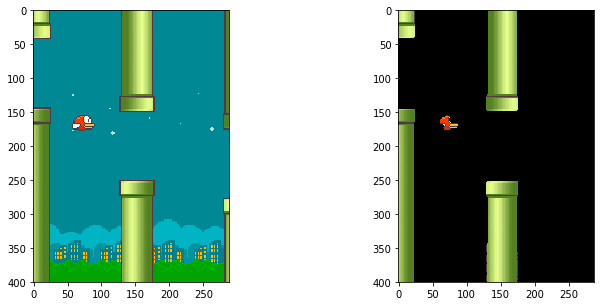

In [215]:
x_test, y_test = generator(1)

image = x_test[0]

net = unet.Unet(channels=3, n_class=3, layers=3, features_root=16)
preds = net.predict("./unet_trained/model.ckpt", np.array([image]))[0]
mask = process_prediction(preds)#[:, :, np.newaxis]
mask = np.pad(mask, 20, mode="reflect")
repair_mask(mask)
#image_small = resize(image, (360, 248, 3))
cut_image = image * mask[:, :, np.newaxis]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(image)
ax2.imshow(cut_image)

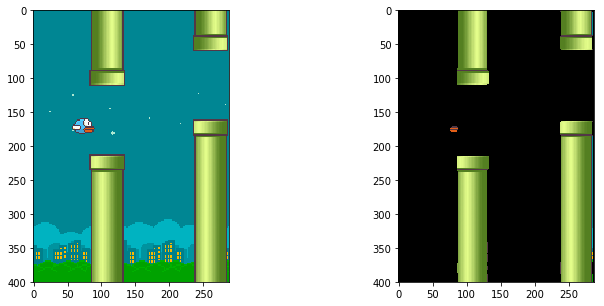

In [231]:
x_test, y_test = generator(1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(x_test[0])
ax2.imshow(cropper.crop_image(x_test[0]))

In [223]:
mask.shape

(400, 288)

/home/evgenii/miniconda3/envs/tf_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/evgenii/miniconda3/envs/tf_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/evgenii/miniconda3/envs/tf_py3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


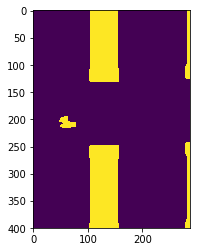

In [50]:
from skimage.transform import resize

mask_ = resize(mask, (400, 288))
mask_ = (mask_ > mask_.mean()).astype(int)
plt.imshow(mask_)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2018-06-25 11:44:10,102 Restoring parameters from ./unet_trained/model.ckpt
2018-06-25 11:44:10,141 Model restored from file: ./unet_trained/model.ckpt


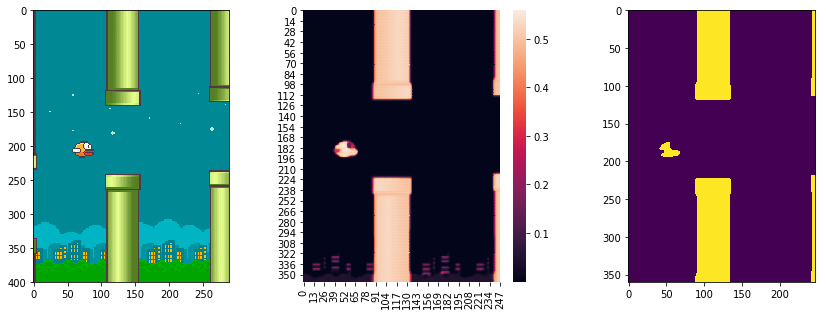

In [49]:
x_test, y_test = generator(1)

prediction = net.predict("./unet_trained/model.ckpt", x_test)

mask = process_prediction(prediction[0])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(x_test[0])
sns.heatmap(prediction[0, :, :, 1], ax=ax2)
ax3.imshow(mask)
#print(score_prediction(mask, y_test[0]))

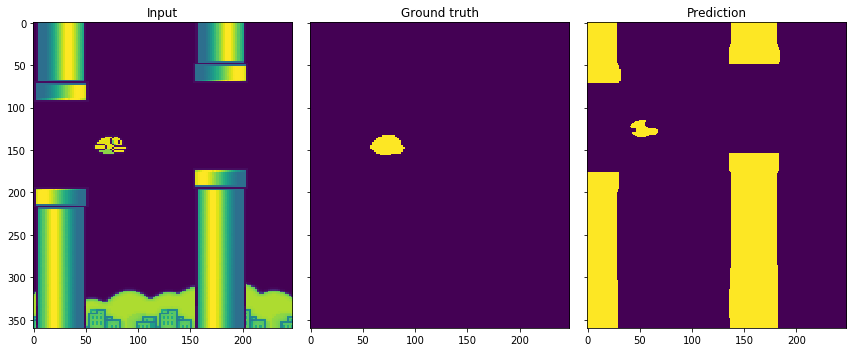

In [61]:

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,2], aspect="auto")
mask = process_prediction(prediction[0])
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")
fig.tight_layout()